In [59]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns


In [60]:
path = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/%s/Results.txt'
path_annotation = '/home/juan/Desktop/juan/bio/mirna_mite/data/introns.gff3'
path_annotation_promoters = '/home/juan/Desktop/juan/bio/mirna_mite/data/promoters.gff3'
path_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv'
path_mirna_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.fasta'
path_mirna_mites_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.mites.y.fasta'
path_mirna_mature = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.mature.csv'
path_res_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta'
experiments = ['mrcv_mites','mrcv_all','sun_all','sun_mites']
path_genome = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.dna.toplevel.fa'
path_blast_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/blast_mites.csv'
path_mirbase = '/home/juan/Desktop/juan/bio/mirna_mite/data/mature.fa'

In [61]:
#Load shortstack results
dfs = {}
for experiment in experiments:
    experiment_path = path % (experiment,)
    df = pd.read_csv(experiment_path, sep='\t')
    df['Name'] = experiment + '_' + df['Name']
    print('Experiment:', experiment)
    print('All results:',len(df.index))
    df = df[df.MIRNA == 'Y']
    print('Only miRNAs:',len(df.index))
#    df = df[df.Reads > 20]
#    print('Only miRNAs +20 reads:',len(df.index))
    df = df[df['21'] > 10]
    print('Only miRNAs 21nt +5 reads:',len(df.index))
    print('*' * 10)
    dfs[experiment] = df

Experiment: mrcv_mites
All results: 1211339
Only miRNAs: 39
Only miRNAs 21nt +5 reads: 21
**********
Experiment: mrcv_all
All results: 38532
Only miRNAs: 135
Only miRNAs 21nt +5 reads: 129
**********
Experiment: sun_all
All results: 157492
Only miRNAs: 154
Only miRNAs 21nt +5 reads: 148
**********
Experiment: sun_mites
All results: 1211339
Only miRNAs: 24
Only miRNAs 21nt +5 reads: 6
**********


In [62]:
dfs = [ v for v in dfs.values() ]

In [63]:
df = pd.concat(dfs)

In [64]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24
125231,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,21,Y,-1.0,0,4,2,38,1,0,0
171085,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,22,Y,-1.0,4,1,1,39,89,63,1


In [65]:
df['seqname'] = df['#Locus'].str.split(':').str[0]
df['position'] = df['#Locus'].str.split(':').str[1]
df['start'] = df.position.str.split('-').str[0].astype(int)
df['end'] = df.position.str.split('-').str[1].astype(int)

In [66]:
print(len(df.index))

304


In [67]:
df[df.index.isin(['876749','876750','876751','27433'])]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
876749,6A:23496429-23496595,mrcv_mites_MITE_T_64052|chr7B|176002823|176003...,167,111,0.871,18,0.045,-,UUAGAGGUUUCAAUACGGACU,82,...,1,1,103,0,1,4,6A,23496429-23496595,23496429,23496595
876750,6A:23496449-23496574,mrcv_mites_MITE_T_70309|chr6D|429354379|429354...,126,108,0.848,18,0.028,-,UUAGAGGUUUCAAUACGGACU,82,...,1,1,102,0,0,4,6A,23496449-23496574,23496449,23496574
876751,6A:23496458-23496565,mrcv_mites_MITE_T_95046|chr2B|521974897|521975...,108,107,0.840,18,0.019,-,UUAGAGGUUUCAAUACGGACU,82,...,0,1,102,0,0,4,6A,23496458-23496565,23496458,23496565
27433,6A:23496419-23496608,mrcv_all_Cluster_27434,190,111,0.871,18,0.045,-,UUAGAGGUUUCAAUACGGACU,82,...,1,1,103,0,1,4,6A,23496419-23496608,23496419,23496608


In [74]:
min_distance = 40
duplicated = []
for k,v in df.iterrows():
    if k in duplicated:
        continue
    other = df[df.index != k]
    other = other[other.seqname == v.seqname]
    other = other[other.MajorRNA == v.MajorRNA]
    other = other[(abs(other.start - v.start) <= min_distance) & (abs(other.end - v.end) <= min_distance)]
    if len(other.index) > 0:
        duplicated += other.index.tolist()

In [75]:
duplicated = set(duplicated)
print(len(duplicated))

32


In [76]:
df.head(3)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
125231,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,4,2,38,1,0,0,1D,147896240-147896319,147896240,147896319
171085,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,1,1,39,89,63,1,2A,168984136-168984233,168984136,168984233
171086,2A:168984152-168984222,mrcv_mites_MITE_T_122259|chr6B|555959095|55595...,71,197,1.546,1,0.041,-,UCGGAAUUAGUUGACACUCAAA,86,...,1,1,39,89,63,1,2A,168984152-168984222,168984152,168984222


In [77]:
df = df[~df.index.isin(duplicated)]
count_total = len(df.index)
count_total

270

In [78]:
df.head(3)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
125231,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,4,2,38,1,0,0,1D,147896240-147896319,147896240,147896319
171085,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,1,1,39,89,63,1,2A,168984136-168984233,168984136,168984233
353559,3A:19302861-19302943,mrcv_mites_MITE_T_105526|chr3A|638201844|63820...,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,2,0,99,4,0,3,3A,19302861-19302943,19302861,19302943


In [79]:
df_mites = df[df.Name.str.contains('MITE')]
count_mites = len(df_mites.index)
count_mites

18

In [80]:
df_nomites = df[~df.Name.str.contains('MITE')]
count_nomites = len(df_nomites.index)
count_nomites

252

In [81]:
count_mites * 100 / count_total

6.666666666666667

In [82]:
#get sequences
df.sort_values(['seqname', 'start'], inplace=True)


In [83]:
fasta_seq = SeqIO.parse(path_genome, 'fasta')
   

In [26]:
buffer_seqs = []
for record in fasta_seq:
    dff_extract = df[df.seqname == record.id]
    print(record.id, len(dff_extract.index))
    clean_seq = ''.join(str(record.seq).splitlines())
    for k,v in dff_extract.iterrows():
        start = min(v.start,v.end)
        end = max(v.start,v.end)
        new_seq = clean_seq[start:end]
        id = v.Name
        desc = record.id + "_" + str(start) + '_' + str(end)
        seq = SeqRecord(Seq(new_seq), id=id, description=desc)
        buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_res_seq, "fasta")
print(path_res_seq)

1A 5
1B 7
1D 6
2A 14
2B 19
2D 5
3A 10
3B 9
3D 13
4A 15
4B 10
4D 9
5A 20
5B 16
5D 21
6A 19
6B 18
6D 17
7A 13
7B 17
7D 5
Un 2
/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta


In [27]:
path_res_seq

'/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta'

In [84]:
df_trep = pd.read_csv(path_blast_res, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep.columns = cols
df_trep = df_trep[df_trep.pident >= 80]
df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep.index))
df_trep.head(2)

500


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,sun_all_Cluster_8835,MITE_1712,1,79,2,80,9,0,88.608,7.860000e-24,79,80,81,99,112
1,sun_all_Cluster_8835,MITE_233,3,77,4,78,8,4,84.416,1.330000e-14,77,80,80,94,78


In [85]:
len(df_trep.qseqid.unique())

28

In [86]:
df_trep['MITE'] = df_trep.groupby(['qseqid'])['sseqid'].transform(lambda x: ','.join(x))


In [87]:
df_trep = df_trep[['qseqid','MITE']]

In [88]:
df_trep.head(2)

,qseqid,MITE
0,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"
1,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"


In [89]:
df_trep = df_trep.drop_duplicates(subset=['qseqid'], keep='first')


In [90]:
df_trep.head(2)

,qseqid,MITE
0,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"
61,mrcv_all_Cluster_2513,"MITE_1151,MITE_1572,MITE_1565,MITE_606,MITE_68..."


In [91]:
len(df_trep.index)

28

In [92]:
df = pd.merge(df, df_trep, how='left', left_on='Name', right_on='qseqid')

In [93]:
df.drop("qseqid", axis=1, inplace=True)

In [94]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,35,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN
1,1A:309399491-309399581,sun_all_Cluster_2789,91,459,3.635,4,0.007,-,ACGGCAUAGAGGCACUGCAAA,196,...,94,298,26,0,5,1A,309399491-309399581,309399491,309399581,NaN


In [95]:
total_count = len(df.index)
total_count

270

In [96]:
df_new_not_mites = df[df.MITE.isnull()]
count_not_mites = len(df_new_not_mites.index)
count_not_mites

242

In [97]:
df_new_mites = df[df.MITE.notnull()]
count_mites = len(df_new_mites.index)
count_mites

28

In [98]:
count_mites * 100 / total_count

10.37037037037037

In [99]:
#mirbase

In [100]:
buffer_seqs = []
for k,v in df.iterrows():
    id = v.Name
    desc = v['#Locus']
    seq = SeqRecord(Seq(v.MajorRNA), id=id, description=desc)
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq)

270
/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.fasta


In [102]:
df_mirbase = pd.read_csv(path_mirna_mature, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mirbase.columns = cols
print(len(df_mirbase.index))
df_mirbase.head(2)

18387


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,sun_all_Cluster_2789,ptc-miR1447,10,20,16,6,0,0,100.0,1.2,11,21,21,52,22
1,mrcv_all_Cluster_1015,tca-miR-6017-5p,5,15,10,20,0,0,100.0,1.3,11,22,20,50,22


In [103]:
allowed_mirbase_mismatches = 7
mirbase_qlen = 4

In [104]:
df_mirbase = df_mirbase[df_mirbase.length > df_mirbase.qlen - mirbase_qlen]
print(len(df_mirbase.index))


15984


In [105]:
df_mirbase = df_mirbase[df_mirbase.mismatch + df_mirbase.gaps <= allowed_mirbase_mismatches]
print(len(df_mirbase.index))


15984


In [106]:
len(df_mirbase.qseqid.unique().tolist())


166

In [107]:
df_mirbase = df_mirbase[['qseqid','sseqid']]


In [108]:
df_mirbase['mirbase'] = df_mirbase.groupby(['qseqid'])['sseqid'].transform(lambda x: ','.join(x))


In [109]:
df_mirbase = df_mirbase[['qseqid','mirbase']]

In [110]:
df_mirbase = df_mirbase.drop_duplicates(subset=['qseqid'], keep='first')


In [111]:
print(len(df_mirbase.index))
df_mirbase.head(2)

166


,qseqid,mirbase
14,sun_all_Cluster_8081,"ata-miR9863b-3p,ata-miR9863a-3p"
17,sun_all_Cluster_8835,hvu-miR6197


In [112]:
df = pd.merge(df, df_mirbase, how='left', left_on='Name', right_on='qseqid')

In [113]:
df.drop("qseqid", axis=1, inplace=True)

In [114]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN
1,1A:309399491-309399581,sun_all_Cluster_2789,91,459,3.635,4,0.007,-,ACGGCAUAGAGGCACUGCAAA,196,...,298,26,0,5,1A,309399491-309399581,309399491,309399581,NaN,NaN


In [115]:
#genomic annotation

In [116]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']


In [117]:
print(len(df_ann.index))


2573211


In [118]:
df_ann = df_ann[
    (df_ann.feature == 'intron') | 
    (df_ann.feature == 'exon') | 
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


1593666


In [119]:
df_ann_promoters = pd.read_csv(path_annotation_promoters, index_col=False, sep='\t', comment='#', header=None)
df_ann_promoters.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann_promoters.index))


120744


In [120]:
df_ann_total = pd.concat([df_ann, df_ann_promoters])


In [121]:
df_ann_total.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...


In [122]:
len(df_ann_total.index)


1714410

In [123]:
df_anns = {}
for chromosome in df_ann_total.seqname.unique():
    df_anns[chromosome] = df_ann_total[df_ann_total.seqname == chromosome]


In [124]:
df.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.34,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN


In [125]:
df['annotation'] = 'intergenic'

In [126]:
for k,v in df.iterrows():
    other = df_anns[v.seqname]
    other = other[(other.end >= v.start) & (other.start <= v.end)]
    if len(other.index) > 0:
        features = set(other.feature.tolist())
        str_features = ', '.join(features)
        if df.loc[k, 'annotation'] == 'three_prime_UTR' or df.loc[k, 'annotation'] == 'five_prime_UTR':
            continue
        df.loc[k, 'annotation'] = str_features

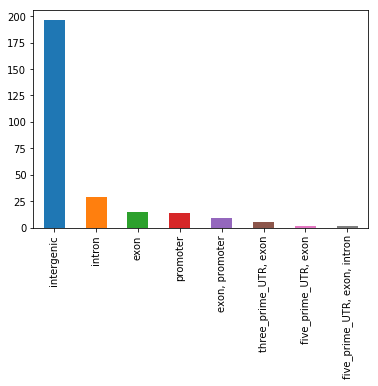

In [127]:
df.annotation.value_counts().plot('bar')

In [128]:
#let's have some fun with data

In [129]:
df[df.MITE.notnull()].annotation.value_counts()

intron                   14
intergenic                9
promoter                  3
three_prime_UTR, exon     2
Name: annotation, dtype: int64

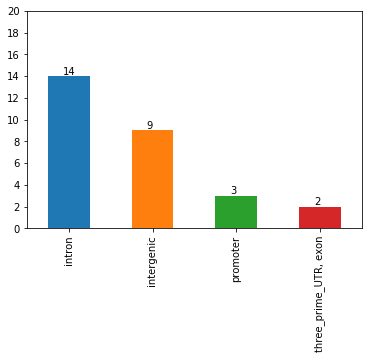

In [130]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df[df.MITE.notnull()].annotation.value_counts().plot('bar')
x_offset = -0.07
y_offset = 0.15
ax.set_ylim(0,20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/mirna_mites_location.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [131]:
len(df.index)

270

In [132]:
print(len(df[df.MITE.notnull()].index))
df[df.MITE.notnull()]

28


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
6,1B:161992200-161992280,sun_all_Cluster_8835,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,"MITE_1712,MITE_233,MITE_1717,MITE_1157",hvu-miR6197,intron
10,1B:565664575-565664794,mrcv_all_Cluster_2513,220,223,1.750,1,0.991,+,CAUUUUCCUAUAGACUUGGUC,142,...,7,0,0,1B,565664575-565664794,565664575,565664794,"MITE_1151,MITE_1572,MITE_1565,MITE_606,MITE_68...",NaN,intron
12,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,1,0,0,1D,147896240-147896319,147896240,147896319,"MITE_1717,MITE_1717,MITE_233,MITE_233,MITE_18,...",NaN,intron
18,2A:133702671-133702770,sun_mites_MITE_T_99232|chr3B|765723509|7657236...,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,...,53,101,2001,2A,133702671-133702770,133702671,133702770,"DTT_Tmon_Icarus_BG607724-1,DTT_Tmon_Icarus_BG6...",NaN,promoter
21,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,89,63,1,2A,168984136-168984233,168984136,168984233,"MITE_253,MITE_253,MITE_293,MITE_1428,DTT_Taes_...",NaN,intron
32,2B:5671327-5671460,sun_all_Cluster_28681,134,562,4.450,504,0.016,-,UAUCUGGACAAAUCUGAGACA,293,...,5,2,4,2B,5671327-5671460,5671327,5671460,"MITE_798,MITE_798,MITE_148,MITE_148,DTT_Hvul_P...",NaN,intron
38,2B:207058615-207058716,sun_mites_MITE_T_100846|chr5D|282007012|282007...,102,21,0.166,8,0.905,+,UGUUCCAUAAUAGUUGUCGCU,7,...,1,0,1,2B,207058615-207058716,207058615,207058716,"MITE_205,MITE_205,MITE_1081,MITE_1428,MITE_293...",bdi-miR5067,promoter
40,2B:482720682-482720772,sun_all_Cluster_33132,91,102,0.808,91,0.078,-,AUCUUCUAUCGUGGGACGAAG,48,...,1,1,1,2B,482720682-482720772,482720682,482720772,"MITE_1444,MITE_1444,MITE_1030,MITE_1030,DTT_Ta...",NaN,intron
47,2B:720801630-720801713,mrcv_all_Cluster_8534,84,505,3.963,486,1.000,+,AUUGAACUAAGGAGGGGUGGA,386,...,5,0,0,2B,720801630-720801713,720801630,720801713,"MITE_1643,MITE_1643",NaN,intron
56,3A:19302861-19302943,mrcv_mites_MITE_T_105526|chr3A|638201844|63820...,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,4,0,3,3A,19302861-19302943,19302861,19302943,"MITE_1128,MITE_1128,MITE_792,MITE_792,MITE_975...",NaN,intron


In [ ]:
list(df[df.MITE.notnull()].MITE.unique())

In [134]:
df[(df.MITE.notnull()) & (df.mirbase.notnull())]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
6,1B:161992200-161992280,sun_all_Cluster_8835,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,"MITE_1712,MITE_233,MITE_1717,MITE_1157",hvu-miR6197,intron
38,2B:207058615-207058716,sun_mites_MITE_T_100846|chr5D|282007012|282007...,102,21,0.166,8,0.905,+,UGUUCCAUAAUAGUUGUCGCU,7,...,1,0,1,2B,207058615-207058716,207058615,207058716,"MITE_205,MITE_205,MITE_1081,MITE_1428,MITE_293...",bdi-miR5067,promoter


In [135]:
df[df.MITE.notnull()][['Name','MajorRNA','MITE','mirbase']]

,Name,MajorRNA,MITE,mirbase
6,sun_all_Cluster_8835,UCUGUUCACAAAUGUAAGACG,"MITE_1712,MITE_233,MITE_1717,MITE_1157",hvu-miR6197
10,mrcv_all_Cluster_2513,CAUUUUCCUAUAGACUUGGUC,"MITE_1151,MITE_1572,MITE_1565,MITE_606,MITE_68...",NaN
12,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,UAUAUUUUGGUACGGAGGGAU,"MITE_1717,MITE_1717,MITE_233,MITE_233,MITE_18,...",NaN
18,sun_mites_MITE_T_99232|chr3B|765723509|7657236...,UGAGACGGGUAAUUUGGAACGGAG,"DTT_Tmon_Icarus_BG607724-1,DTT_Tmon_Icarus_BG6...",NaN
21,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,UCGGAAUUAGUUGACACUCAAA,"MITE_253,MITE_253,MITE_293,MITE_1428,DTT_Taes_...",NaN
32,sun_all_Cluster_28681,UAUCUGGACAAAUCUGAGACA,"MITE_798,MITE_798,MITE_148,MITE_148,DTT_Hvul_P...",NaN
38,sun_mites_MITE_T_100846|chr5D|282007012|282007...,UGUUCCAUAAUAGUUGUCGCU,"MITE_205,MITE_205,MITE_1081,MITE_1428,MITE_293...",bdi-miR5067
40,sun_all_Cluster_33132,AUCUUCUAUCGUGGGACGAAG,"MITE_1444,MITE_1444,MITE_1030,MITE_1030,DTT_Ta...",NaN
47,mrcv_all_Cluster_8534,AUUGAACUAAGGAGGGGUGGA,"MITE_1643,MITE_1643",NaN
56,mrcv_mites_MITE_T_105526|chr3A|638201844|63820...,UCCAAUUACUCGUCGUGGUUU,"MITE_1128,MITE_1128,MITE_792,MITE_792,MITE_975...",NaN


In [136]:
df[(df.MITE.notnull()) & (df.mirbase.notnull())]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
6,1B:161992200-161992280,sun_all_Cluster_8835,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,"MITE_1712,MITE_233,MITE_1717,MITE_1157",hvu-miR6197,intron
38,2B:207058615-207058716,sun_mites_MITE_T_100846|chr5D|282007012|282007...,102,21,0.166,8,0.905,+,UGUUCCAUAAUAGUUGUCGCU,7,...,1,0,1,2B,207058615-207058716,207058615,207058716,"MITE_205,MITE_205,MITE_1081,MITE_1428,MITE_293...",bdi-miR5067,promoter


In [137]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

270
/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv
